Colab Notebook Code stats checks and tests (RQ3)
1) 🔧
 Setup & Upload

In [1]:
# --- Cell 1: Imports & Colab file upload ---
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# In Colab, use the uploader to pick your two files:
# - MQTT local 1000 message of each Qos Level.csv
# - MQTT wifi 1000 message of each Qos Level.csv
try:
    from google.colab import files
    uploaded = files.upload()  # Select both CSVs
    print("Uploaded:", list(uploaded.keys()))
except Exception as e:
    print("If not using Colab, set file paths manually below.", e)

# Helper to read either from uploaded dict or local path
def read_csv_smart(name_or_path):
    if "uploaded" in globals() and isinstance(uploaded, dict) and name_or_path in uploaded:
        return pd.read_csv(io.BytesIO(uploaded[name_or_path]))
    return pd.read_csv(name_or_path)

# If your filenames differ, update these two names:
LOCAL_CSV = "MQTT local 1000 message of each Qos Level.csv"
WIFI_CSV  = "MQTT wifi 1000 message of each Qos Level.csv"

df_local = read_csv_smart(LOCAL_CSV)
df_wifi  = read_csv_smart(WIFI_CSV)

print("Local shape:", df_local.shape, " | WiFi shape:", df_wifi.shape)


Saving MQTT local 1000 message of each Qos Level.csv to MQTT local 1000 message of each Qos Level.csv
Saving MQTT wifi 1000 message of each Qos Level.csv to MQTT wifi 1000 message of each Qos Level.csv
Uploaded: ['MQTT local 1000 message of each Qos Level.csv', 'MQTT wifi 1000 message of each Qos Level.csv']
Local shape: (3000, 13)  | WiFi shape: (3000, 13)


2) Metric Functions (same formulas as your GUI)

In [2]:
# --- Cell 2: Metric evaluation helpers (QoS-wise) ---
REQUIRED_COLS = [
    "run_id","qos","msg_id","topic_name","msg_context","pub_ts","recv_ts",
    "delay_s","delay_ms","declared_size_bytes","wire_size_bytes","pub_device","sub_device"
]

def validate_columns(df):
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"CSV missing columns: {missing}")

def to_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def evaluate_mqtt_qos(df, test_name, sent_per_qos=1000):
    validate_columns(df)
    num_cols = ["qos","msg_id","pub_ts","recv_ts","delay_s","delay_ms","declared_size_bytes","wire_size_bytes"]
    to_numeric(df, num_cols)

    results = []
    for qos in sorted(df["qos"].dropna().unique()):
        qos = int(qos)
        dfq = df[df["qos"] == qos].copy()

        received = int(dfq["msg_id"].nunique())
        mean_ms  = dfq["delay_ms"].mean()
        std_ms   = dfq["delay_ms"].std()

        # throughput: received / (recv_ts range)
        if len(dfq) >= 2:
            duration = dfq["recv_ts"].max() - dfq["recv_ts"].min()
            thr = received / duration if duration > 0 else np.nan
        else:
            thr = np.nan

        reliab = (received / sent_per_qos) * 100.0

        # duplicates: extra copies beyond first per msg_id
        dupe_counts = dfq.groupby("msg_id").size()
        dupes = int((dupe_counts - 1).clip(lower=0).sum())
        dup_rate = (dupes / len(dfq)) * 100.0 if len(dfq) > 0 else 0.0
        avg_size = dfq["wire_size_bytes"].mean()

        results.append({
            "Test": test_name,
            "QoS": qos,
            "Received": received,
            "Mean Latency (ms)": mean_ms,
            "Std Latency (ms)": std_ms,
            "Reliability (%)": reliab,
            "Throughput (msg/s)": thr,
            "Duplicates": dupes,
            "Duplicate Rate (%)": dup_rate,
            "Avg Size (bytes)": avg_size
        })
    out = pd.DataFrame(results)
    # nice rounding for display (keep a raw copy if needed)
    return out.round({
        "Mean Latency (ms)": 3, "Std Latency (ms)": 3, "Reliability (%)": 2,
        "Throughput (msg/s)": 3, "Duplicate Rate (%)": 3, "Avg Size (bytes)": 1
    })


3) Compute Summaries (Local vs Wi-Fi)

In [3]:
# --- Cell 3: Compute summaries ---
summary_local = evaluate_mqtt_qos(df_local, "Local", sent_per_qos=1000)
summary_wifi  = evaluate_mqtt_qos(df_wifi, "WiFi",  sent_per_qos=1000)
summary_all   = pd.concat([summary_local, summary_wifi], ignore_index=True)

print("Local Summary:")
display(summary_local)
print("WiFi Summary:")
display(summary_wifi)
print("All:")
display(summary_all)

# Save the combined summary for your report
summary_path = "RQ3_MQTT_QoS_Summary.csv"
summary_all.to_csv(summary_path, index=False)
print("Saved:", summary_path)


Local Summary:


,Test,QoS,Received,Mean Latency (ms),Std Latency (ms),Reliability (%),Throughput (msg/s),Duplicates,Duplicate Rate (%),Avg Size (bytes)
0,Local,0,1000,0.293,0.059,100.0,9.993,0,0.0,121.6
1,Local,1,1000,0.351,0.194,100.0,9.955,0,0.0,121.6
2,Local,2,1000,0.517,0.216,100.0,9.961,0,0.0,121.6


WiFi Summary:


,Test,QoS,Received,Mean Latency (ms),Std Latency (ms),Reliability (%),Throughput (msg/s),Duplicates,Duplicate Rate (%),Avg Size (bytes)
0,WiFi,0,1000,25.590,4.154,100.0,9.899,0,0.0,125.6
1,WiFi,1,1000,26.123,2.502,100.0,9.130,0,0.0,125.6
2,WiFi,2,1000,32.463,9.970,100.0,8.774,0,0.0,125.6


All:


,Test,QoS,Received,Mean Latency (ms),Std Latency (ms),Reliability (%),Throughput (msg/s),Duplicates,Duplicate Rate (%),Avg Size (bytes)
0,Local,0,1000,0.293,0.059,100.0,9.993,0,0.0,121.6
1,Local,1,1000,0.351,0.194,100.0,9.955,0,0.0,121.6
2,Local,2,1000,0.517,0.216,100.0,9.961,0,0.0,121.6
3,WiFi,0,1000,25.590,4.154,100.0,9.899,0,0.0,125.6
4,WiFi,1,1000,26.123,2.502,100.0,9.130,0,0.0,125.6
5,WiFi,2,1000,32.463,9.970,100.0,8.774,0,0.0,125.6


Saved: RQ3_MQTT_QoS_Summary.csv


4) Plotting Utilities

In [4]:
# --- Cell 4: Plot helpers (matplotlib only, no seaborn) ---
def plot_metric(df_local, df_wifi, metric, ylabel, fname, ylim=None):
    """
    Side-by-side bar chart for QoS=0,1,2 comparing Local vs WiFi for a given metric.
    """
    qos_levels = [0, 1, 2]
    local_vals = [float(df_local.loc[df_local["QoS"] == q, metric].values[0]) for q in qos_levels]
    wifi_vals  = [float(df_wifi.loc[df_wifi["QoS"] == q, metric].values[0])  for q in qos_levels]

    x = np.arange(len(qos_levels))
    width = 0.35

    plt.figure(figsize=(8, 5))
    plt.bar(x - width/2, local_vals, width, label="Local")
    plt.bar(x + width/2, wifi_vals,  width, label="WiFi")
    plt.xticks(x, qos_levels)
    plt.xlabel("QoS")
    plt.ylabel(ylabel)
    plt.title(f"{metric} by QoS (Local vs WiFi)")
    if ylim is not None:
        plt.ylim(ylim)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved plot:", fname)


5) Generate All RQ3 Plots


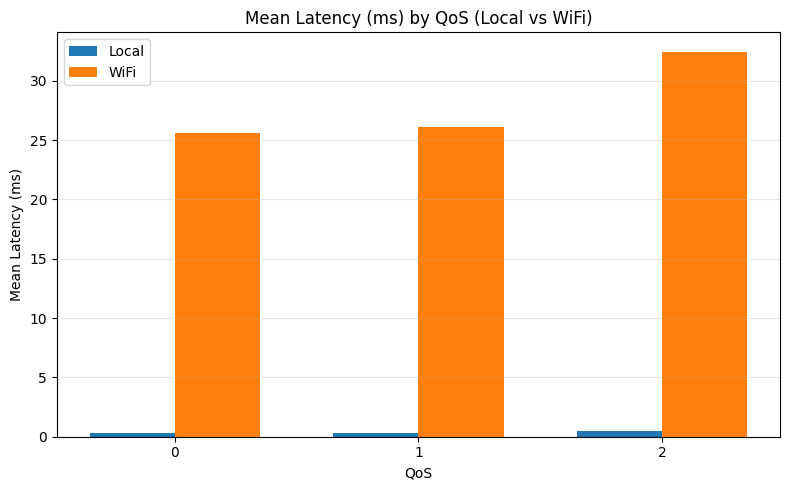

Saved plot: RQ3_Fig1_MeanLatency_vs_QoS.png


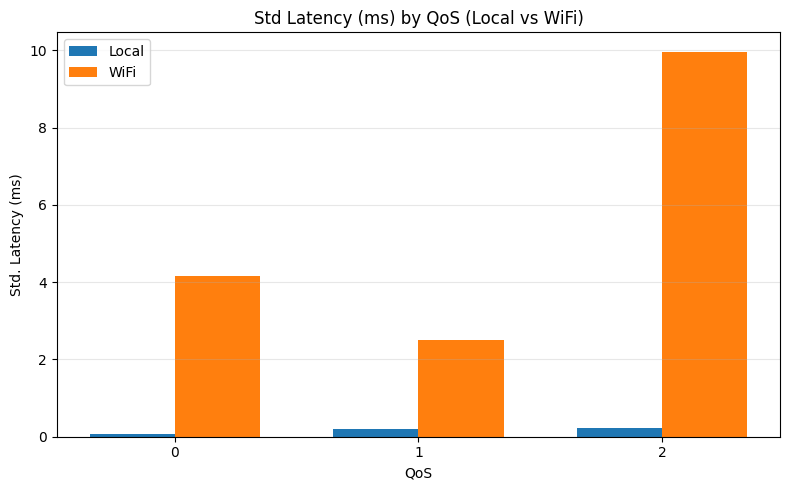

Saved plot: RQ3_Fig2_StdLatency_vs_QoS.png


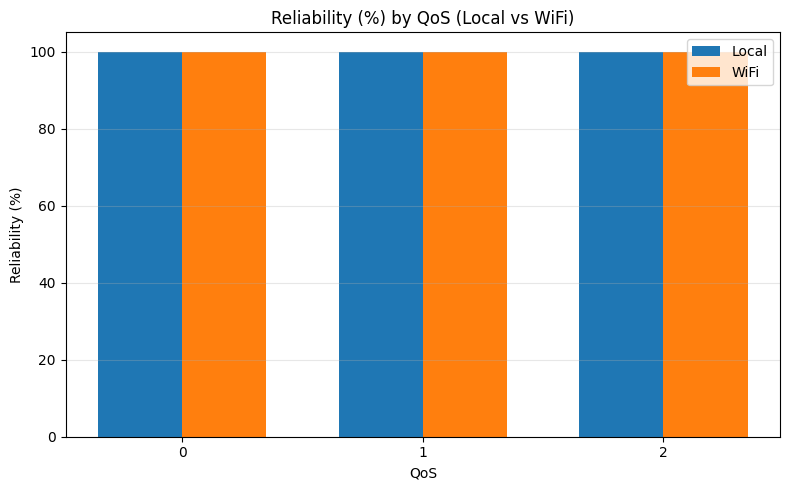

Saved plot: RQ3_Fig3_Reliability_vs_QoS.png


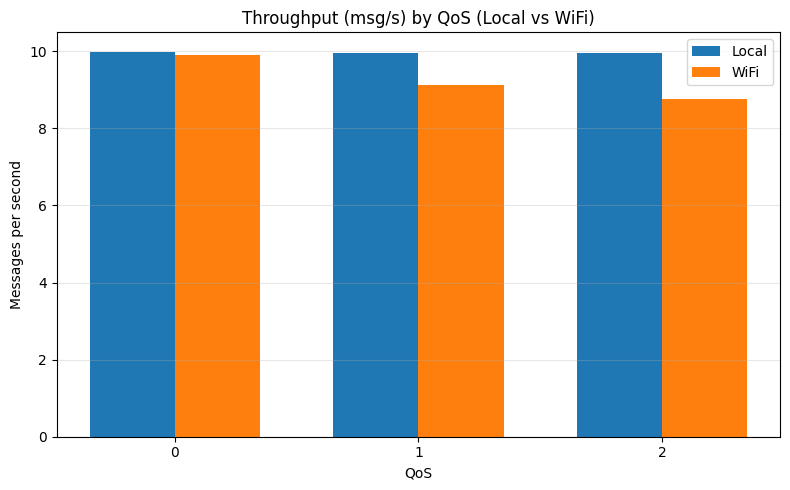

Saved plot: RQ3_Fig4_Throughput_vs_QoS.png


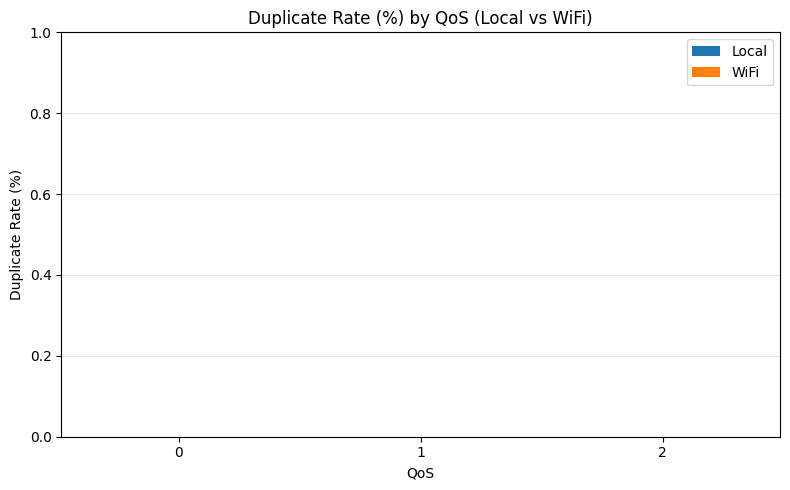

Saved plot: RQ3_Fig5_DuplicateRate_vs_QoS.png


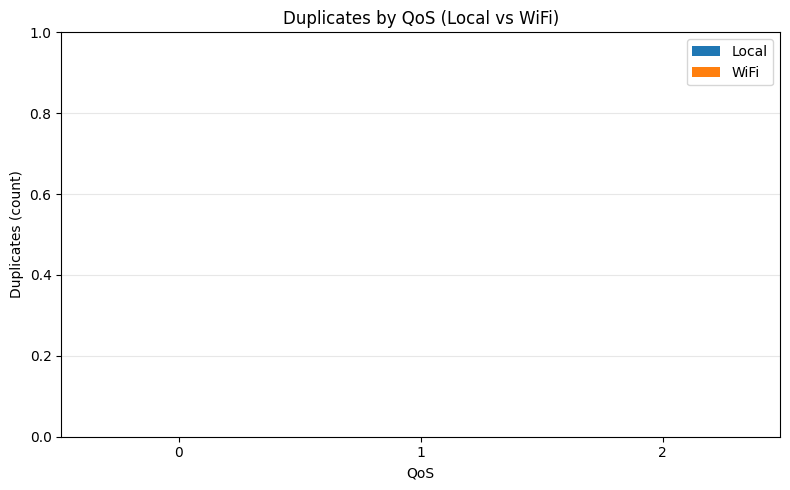

Saved plot: RQ3_Fig6_Duplicates_vs_QoS.png


In [5]:
# --- Cell 5: Create the figures for the report ---

# Latency
plot_metric(summary_local, summary_wifi,
            metric="Mean Latency (ms)",
            ylabel="Mean Latency (ms)",
            fname="RQ3_Fig1_MeanLatency_vs_QoS.png")

# Latency Std (Jitter)
plot_metric(summary_local, summary_wifi,
            metric="Std Latency (ms)",
            ylabel="Std. Latency (ms)",
            fname="RQ3_Fig2_StdLatency_vs_QoS.png")

# Reliability
plot_metric(summary_local, summary_wifi,
            metric="Reliability (%)",
            ylabel="Reliability (%)",
            fname="RQ3_Fig3_Reliability_vs_QoS.png",
            ylim=(0, 105))

# Throughput
plot_metric(summary_local, summary_wifi,
            metric="Throughput (msg/s)",
            ylabel="Messages per second",
            fname="RQ3_Fig4_Throughput_vs_QoS.png")

# Duplicate Rate
plot_metric(summary_local, summary_wifi,
            metric="Duplicate Rate (%)",
            ylabel="Duplicate Rate (%)",
            fname="RQ3_Fig5_DuplicateRate_vs_QoS.png",
            ylim=(0, max(1, float(summary_all["Duplicate Rate (%)"].max()) * 1.2)))

# Duplicates count (optional)
plot_metric(summary_local, summary_wifi,
            metric="Duplicates",
            ylabel="Duplicates (count)",
            fname="RQ3_Fig6_Duplicates_vs_QoS.png",
            ylim=(0, max(1, float(summary_all["Duplicates"].max()) * 1.2)))


Colab Notebook Code stats checks and tests (RQ3)
1) 🔧 Setup + Helper Functions (APA formatting, CI, normality/homoskedasticity checks, ANOVA/Kruskal, post-hoc)

In [6]:
# If you already ran the earlier notebook and have df_local/df_wifi in memory,
# this uploader is optional. Otherwise, select both CSVs when prompted.
import io, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, f_oneway, kruskal, ttest_ind
from math import sqrt
try:
    from google.colab import files
    uploaded = uploaded  # reuse if already defined
except:
    uploaded = None

def maybe_upload_and_read():
    global uploaded
    try:
        from google.colab import files
        uploaded = files.upload()  # select: local + wifi CSVs
        print("Uploaded:", list(uploaded.keys()))
        def read_csv_smart(k):
            return pd.read_csv(io.BytesIO(uploaded[k]))
        return read_csv_smart
    except Exception as e:
        print("Skipping upload (not in Colab or already loaded).", e)
        return None

# If df_local/df_wifi don't exist, try to create them here:
if "df_local" not in globals() or "df_wifi" not in globals():
    reader = maybe_upload_and_read()
    if reader:
        LOCAL_CSV = "MQTT local 1000 message of each Qos Level.csv"
        WIFI_CSV  = "MQTT wifi 1000 message of each Qos Level.csv"
        df_local = reader(LOCAL_CSV)
        df_wifi  = reader(WIFI_CSV)

# ---------- Helpers ----------
def to_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

def ci_mean(x, alpha=0.05):
    """Return (mean, lowerCI, upperCI) using normal approx (large n)."""
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = len(x)
    if n == 0:
        return np.nan, np.nan, np.nan
    m = x.mean()
    s = x.std(ddof=1) if n > 1 else 0.0
    z = 1.96 if abs(alpha-0.05) < 1e-9 else 1.96  # keep simple
    half = z * (s / sqrt(max(n,1)))
    return m, m - half, m + half

def apa_p(p):
    if p < .001: return "p < .001"
    return f"p = {p:.3f}"

def print_apa_anova(name, F, p, df_between, df_within):
    print(f"{name}: One-way ANOVA, F({df_between:.0f}, {df_within:.0f}) = {F:.3f}, {apa_p(p)}")

def print_apa_kw(name, H, p, k):
    print(f"{name}: Kruskal–Wallis H({k-1}) = {H:.3f}, {apa_p(p)}")

def bonferroni_pairs(groups, labels, metric_name):
    """Welch's t-tests between all pairs, Bonferroni-corrected p."""
    print(f"\nPost-hoc pairwise (Welch's t) for {metric_name} with Bonferroni correction:")
    k = len(groups)
    m = k*(k-1)/2
    for i in range(k):
        for j in range(i+1, k):
            a, b = np.asarray(groups[i], float), np.asarray(groups[j], float)
            a, b = a[np.isfinite(a)], b[np.isfinite(b)]
            if len(a) > 1 and len(b) > 1:
                stat, p = ttest_ind(a, b, equal_var=False)
                p_corr = min(p * m, 1.0)
                print(f"  {labels[i]} vs {labels[j]}: t = {stat:.3f}, raw {apa_p(p)}, Bonferroni {apa_p(p_corr)}")
            else:
                print(f"  {labels[i]} vs {labels[j]}: insufficient data")

def run_qos_tests_latency(df, dataset_label="WiFi"):
    """Run normality, homogeneity, and then ANOVA or Kruskal for delay_ms across QoS 0/1/2."""
    to_numeric(df, ["qos","delay_ms"])
    groups, labels = [], []
    for q in [0,1,2]:
        x = df.loc[df["qos"]==q, "delay_ms"].dropna().values
        if len(x) == 0:
            print(f"{dataset_label} QoS {q}: no data.")
        groups.append(x); labels.append(f"QoS{q}")

    # Basic sanity
    if any(len(g)==0 for g in groups):
        print(f"{dataset_label}: Not enough data in one or more QoS groups.")
        return

    # Normality check (Shapiro; large n may always reject—consider visual checks too)
    print(f"\n=== {dataset_label}: Latency (delay_ms) — Assumption checks ===")
    for lab, g in zip(labels, groups):
        if len(g) >= 3:
            W, p = shapiro(g[:5000])  # cap for speed; Shapiro not recommended for very large n
            print(f"  {lab}: Shapiro W={W:.3f}, {apa_p(p)} (n={len(g)})")
        else:
            print(f"  {lab}: Shapiro skipped (n<3)")

    # Homogeneity (Levene)
    lev_stat, lev_p = levene(*groups, center='median')
    print(f"  Levene (median): W={lev_stat:.3f}, {apa_p(lev_p)}")

    # Decide test: ANOVA if roughly normal + homogenous; else Kruskal
    k = len(groups)
    if lev_p >= 0.05:
        # ANOVA
        F, p = f_oneway(*groups)
        # df_between = k - 1, df_within = N - k
        df_between = k - 1
        N = sum(len(g) for g in groups)
        df_within = N - k
        print(f"\n=== {dataset_label}: Latency — Omnibus test ===")
        print_apa_anova(f"{dataset_label} latency", F, p, df_between, df_within)
    else:
        # Kruskal–Wallis
        H, p = kruskal(*groups)
        print(f"\n=== {dataset_label}: Latency — Omnibus test ===")
        print_apa_kw(f"{dataset_label} latency", H, p, k)

    # Always show post-hoc t-tests with Bonferroni (transparent, even if Levene failed)
    bonferroni_pairs(groups, labels, metric_name=f"{dataset_label} latency")

def make_latency_table_with_ci(df, title):
    rows = []
    for q in [0,1,2]:
        x = df.loc[df["qos"]==q, "delay_ms"].dropna().values
        m, lo, hi = ci_mean(x, alpha=0.05)
        rows.append({"QoS": q, "N": len(x),
                     "Mean (ms)": m, "95% CI Low": lo, "95% CI High": hi})
    out = pd.DataFrame(rows).round(3)
    print(f"\n{title} — Mean latency with 95% CI")
    display(out)
    return out


2) Run Tests + Print APA-Style Results + CI Tables

In [7]:
# Latency (delay_ms) is the right metric for inferential tests.
# Reliability is 100% for all QoS here (no variance) => not suitable for ANOVA.
# Throughput is an aggregate per-QoS; to do inferential tests on throughput you'd
# need a per-interval series (e.g., msgs/sec bins). We keep the robust focus on latency.

print("Running latency significance tests across QoS (0/1/2)…")

# Local
run_qos_tests_latency(df_local, dataset_label="Local")
local_ci = make_latency_table_with_ci(df_local, "Local")

# WiFi
run_qos_tests_latency(df_wifi, dataset_label="WiFi")
wifi_ci = make_latency_table_with_ci(df_wifi, "WiFi")


Running latency significance tests across QoS (0/1/2)…

=== Local: Latency (delay_ms) — Assumption checks ===
  QoS0: Shapiro W=0.879, p < .001 (n=1000)
  QoS1: Shapiro W=0.440, p < .001 (n=1000)
  QoS2: Shapiro W=0.529, p < .001 (n=1000)
  Levene (median): W=43.578, p < .001

=== Local: Latency — Omnibus test ===
Local latency: Kruskal–Wallis H(2) = 1450.276, p < .001

Post-hoc pairwise (Welch's t) for Local latency with Bonferroni correction:
  QoS0 vs QoS1: t = -9.062, raw p < .001, Bonferroni p < .001
  QoS0 vs QoS2: t = -31.586, raw p < .001, Bonferroni p < .001
  QoS1 vs QoS2: t = -18.027, raw p < .001, Bonferroni p < .001

Local — Mean latency with 95% CI


,QoS,N,Mean (ms),95% CI Low,95% CI High
0,0,1000,0.293,0.289,0.297
1,1,1000,0.351,0.339,0.363
2,2,1000,0.517,0.503,0.530



=== WiFi: Latency (delay_ms) — Assumption checks ===
  QoS0: Shapiro W=0.483, p < .001 (n=1000)
  QoS1: Shapiro W=0.499, p < .001 (n=1000)
  QoS2: Shapiro W=0.359, p < .001 (n=1000)
  Levene (median): W=49.147, p < .001

=== WiFi: Latency — Omnibus test ===
WiFi latency: Kruskal–Wallis H(2) = 1673.678, p < .001

Post-hoc pairwise (Welch's t) for WiFi latency with Bonferroni correction:
  QoS0 vs QoS1: t = -3.481, raw p < .001, Bonferroni p = 0.002
  QoS0 vs QoS2: t = -20.125, raw p < .001, Bonferroni p < .001
  QoS1 vs QoS2: t = -19.504, raw p < .001, Bonferroni p < .001

WiFi — Mean latency with 95% CI


,QoS,N,Mean (ms),95% CI Low,95% CI High
0,0,1000,25.590,25.332,25.847
1,1,1000,26.123,25.968,26.279
2,2,1000,32.463,31.845,33.081


3) Error-Bar Plots (Mean ± 95% CI) for Latency

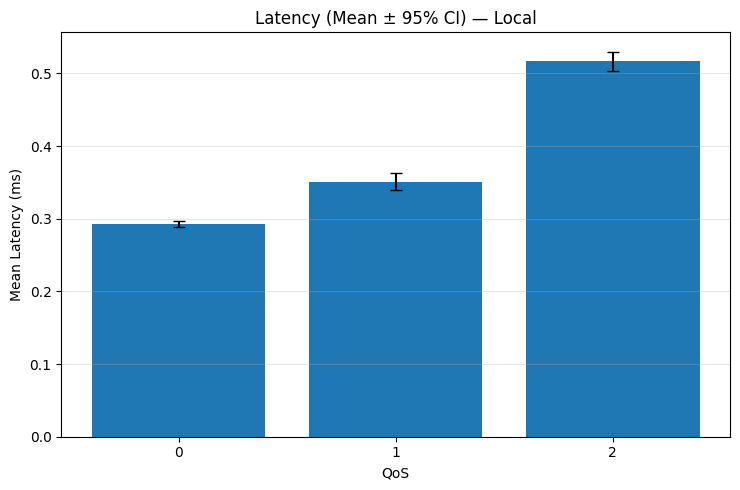

Saved: RQ3_Latency_CI_Local.png


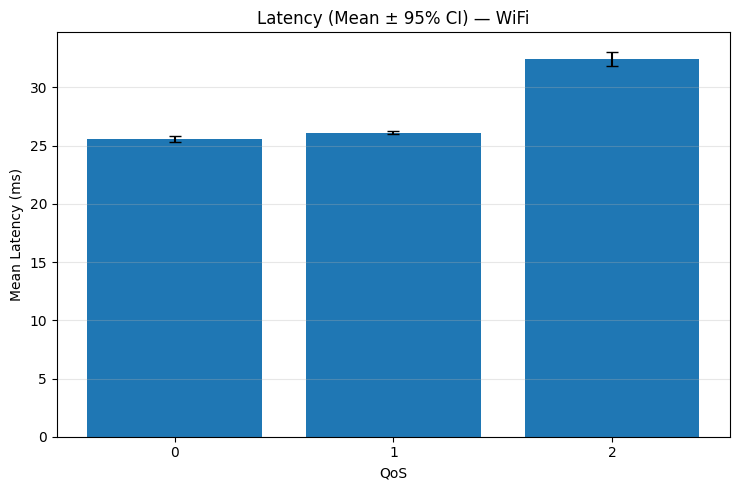

Saved: RQ3_Latency_CI_WiFi.png


In [8]:
def plot_latency_with_ci(ci_table, label, fname):
    qos = ci_table["QoS"].values
    mean = ci_table["Mean (ms)"].values
    low  = ci_table["95% CI Low"].values
    high = ci_table["95% CI High"].values
    err = np.vstack([mean - low, high - mean])

    plt.figure(figsize=(7.5, 5))
    plt.bar(qos, mean, yerr=err, capsize=4)
    plt.xlabel("QoS")
    plt.ylabel("Mean Latency (ms)")
    plt.title(f"Latency (Mean ± 95% CI) — {label}")
    plt.xticks([0,1,2], [0,1,2])
    plt.grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.savefig(fname, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", fname)

plot_latency_with_ci(local_ci, "Local", "RQ3_Latency_CI_Local.png")
plot_latency_with_ci(wifi_ci,  "WiFi",  "RQ3_Latency_CI_WiFi.png")
